# **Using MLP_Fabricated Data**


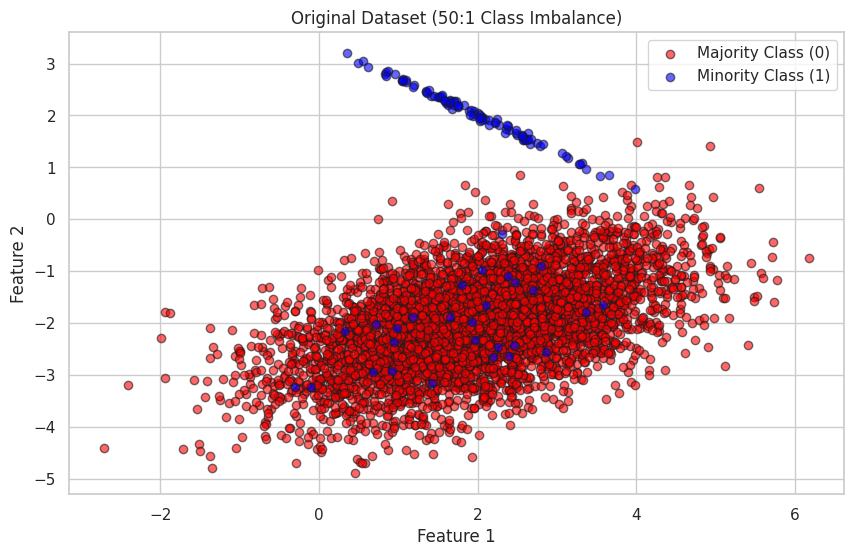

 16%|█▋        | 165/1000 [00:00<00:00, 842.30it/s]

Epoch 0, Loss: 0.9471108913421631
Epoch 100, Loss: 0.5935413241386414


 35%|███▍      | 347/1000 [00:00<00:00, 831.39it/s]

Epoch 200, Loss: 0.25736892223358154
Epoch 300, Loss: 0.6723198294639587


 53%|█████▎    | 528/1000 [00:00<00:00, 833.63it/s]

Epoch 400, Loss: 0.42633721232414246
Epoch 500, Loss: 0.571668803691864


 72%|███████▏  | 718/1000 [00:00<00:00, 895.05it/s]

Epoch 600, Loss: 0.40726250410079956
Epoch 700, Loss: 0.42108026146888733


 90%|█████████ | 901/1000 [00:01<00:00, 888.79it/s]

Epoch 800, Loss: 0.2969323992729187
Epoch 900, Loss: 0.5659705400466919


100%|██████████| 1000/1000 [00:01<00:00, 848.49it/s]


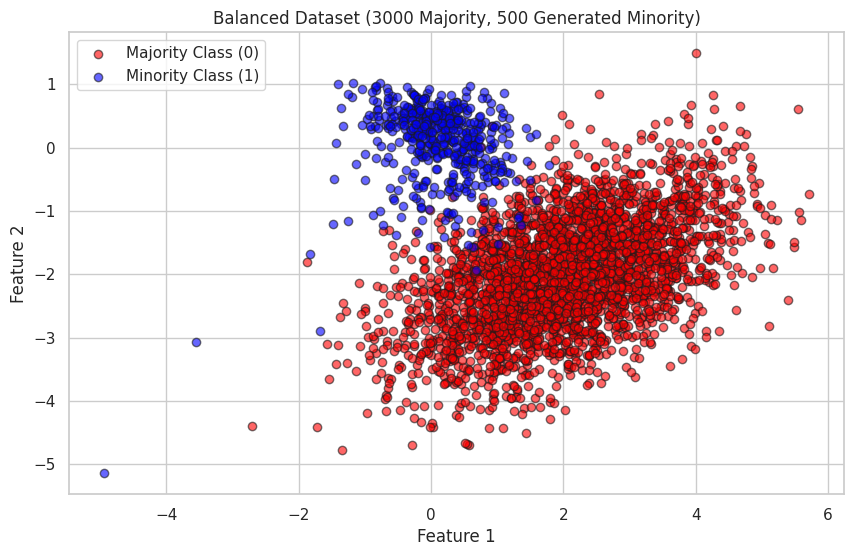

F1 Score on Original Data: 0.8116
F1 Score on Balanced Data: 0.9613
Original F1 Score: 0.8116
Balanced (Generated) F1 Score: 0.9613


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Diffusion Hyperparameters
T = 1000  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)  # Shape (T,)
alphas = 1 - betas  # Shape (T,)
alphas_bar = torch.cumprod(alphas, dim=0)  # Shape (T,)

# Helper to add noise in the forward diffusion process
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alpha_bar_t = torch.sqrt(alphas_bar[t]).view(-1, 1)  # (batch_size, 1)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alphas_bar[t]).view(-1, 1)  # (batch_size, 1)
    return sqrt_alpha_bar_t * x_start + sqrt_one_minus_alpha_bar_t * noise

# MLP model for noise prediction
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x, t):
        time_emb = torch.sin(t.unsqueeze(1) * 0.01)
        x = torch.cat([x, time_emb], dim=1)
        return self.model(x)

# Reverse process (denoising)
def p_sample(model, x_t, t):
    noise_pred = model(x_t, t)
    beta_t = betas[t].view(-1, 1)
    alpha_t = alphas[t].view(-1, 1)
    alpha_bar_t = alphas_bar[t].view(-1, 1)
    sqrt_alpha_t = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
    mean = (1 / sqrt_alpha_t) * (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * noise_pred)
    noise = torch.randn_like(x_t) if t[0] > 0 else torch.zeros_like(x_t)
    return mean + torch.sqrt(beta_t) * noise

# Sampling process to generate data
def generate_sample(model, input_dim, num_samples):
    x = torch.randn((num_samples, input_dim))
    for t in reversed(range(T)):
        t_tensor = torch.tensor([t] * num_samples)
        x = p_sample(model, x, t_tensor)
    return x

# Step 1: Generate Synthetic Binary Dataset (50:1 ratio)
X, y = make_classification(n_samples=5000, n_features=2, n_classes=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_clusters_per_class=1, weights=[0.98, 0.02],
                           class_sep=2, random_state=42)

df = pd.DataFrame(X, columns=["Feature 1", "Feature 2"])
df['target'] = y

# Step 2: Identify the minority class
minority_class = df[df['target'] == 1]
majority_class = df[df['target'] == 0]

# Plot the original imbalanced dataset
def plot_data(original_df, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(original_df[original_df['target'] == 0]['Feature 1'], original_df[original_df['target'] == 0]['Feature 2'],
                label='Majority Class (0)', color='red', alpha=0.6, edgecolor='k')
    plt.scatter(original_df[original_df['target'] == 1]['Feature 1'], original_df[original_df['target'] == 1]['Feature 2'],
                label='Minority Class (1)', color='blue', alpha=0.6, edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_data(df, title="Original Dataset (50:1 Class Imbalance)")

# Step 3: Split minority class data into train and test sets
train_minority, test_minority = train_test_split(minority_class, test_size=0.3, random_state=42)

# Normalize the minority class training data
train_data = train_minority.drop('target', axis=1)
train_data_tensor = torch.tensor(
    (train_data.values - train_data.values.mean(axis=0)) / train_data.values.std(axis=0),
    dtype=torch.float32
)

# Step 4: Train Diffusion Model on the minority class training data
num_features = train_data_tensor.shape[1]
model = SimpleMLP(input_dim=num_features + 1, output_dim=num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 1000
batch_size = 16
for epoch in tqdm(range(epochs)):
    idx = np.random.randint(0, train_data_tensor.shape[0], size=batch_size)
    x_start = train_data_tensor[idx]
    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start, t, noise)
    noise_pred = model(x_noisy, t)
    loss = loss_fn(noise_pred, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Step 5: Generate 500 samples of the minority class
num_generated_samples = 500
generated_data = generate_sample(model, num_features, num_generated_samples)

# Convert generated samples to DataFrame
generated_df = pd.DataFrame(generated_data.detach().numpy(), columns=["Feature 1", "Feature 2"])
generated_df['target'] = 1  # Assign minority class label

# Mix the generated minority class with 3000 samples from the majority class
selected_majority = majority_class.sample(n=3000, random_state=42)
balanced_df = pd.concat([selected_majority, generated_df])

# Plot the balanced dataset
plot_data(balanced_df, title="Balanced Dataset (3000 Majority, 500 Generated Minority)")

# Step 6: Train Logistic Regression on Original Data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, random_state=42)

log_reg_orig = LogisticRegression(solver='liblinear')
log_reg_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = log_reg_orig.predict(X_test_orig)
f1_score_orig = f1_score(y_test_orig, y_pred_orig)
print(f"F1 Score on Original Data: {f1_score_orig:.4f}")

# Step 7: Train Logistic Regression on Combined Generated and Selected Majority Data
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_df.drop('target', axis=1), balanced_df['target'], test_size=0.3, random_state=42)

log_reg_balanced = LogisticRegression(solver='liblinear')
log_reg_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = log_reg_balanced.predict(X_test_balanced)
f1_score_balanced = f1_score(y_test_balanced, y_pred_balanced)
print(f"F1 Score on Balanced Data: {f1_score_balanced:.4f}")

# Comparison of F1 Scores
print(f"Original F1 Score: {f1_score_orig:.4f}")
print(f"Balanced (Generated) F1 Score: {f1_score_balanced:.4f}")


# **MLP_creditcard**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.1755

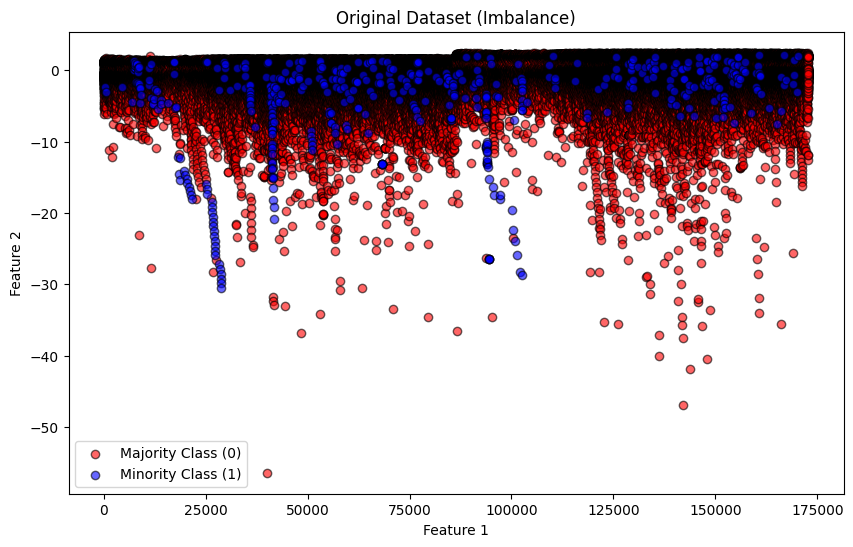

  7%|▋         | 74/1000 [00:00<00:02, 370.68it/s]

Epoch 0, Loss: 0.9921169877052307


 16%|█▌        | 160/1000 [00:00<00:02, 390.45it/s]

Epoch 100, Loss: 0.5927360653877258


 24%|██▍       | 243/1000 [00:00<00:01, 392.10it/s]

Epoch 200, Loss: 0.3770833909511566


 32%|███▏      | 324/1000 [00:00<00:01, 343.25it/s]

Epoch 300, Loss: 0.30924519896507263


 46%|████▌     | 455/1000 [00:01<00:01, 294.42it/s]

Epoch 400, Loss: 0.32922205328941345


 54%|█████▍    | 544/1000 [00:01<00:01, 274.41it/s]

Epoch 500, Loss: 0.29554179310798645


 64%|██████▎   | 637/1000 [00:02<00:01, 297.41it/s]

Epoch 600, Loss: 0.3266633152961731


 76%|███████▌  | 760/1000 [00:02<00:00, 290.88it/s]

Epoch 700, Loss: 0.22491370141506195


 85%|████████▌ | 850/1000 [00:02<00:00, 269.37it/s]

Epoch 800, Loss: 0.2148628979921341


 93%|█████████▎| 934/1000 [00:03<00:00, 260.45it/s]

Epoch 900, Loss: 0.18288269639015198


100%|██████████| 1000/1000 [00:03<00:00, 296.50it/s]


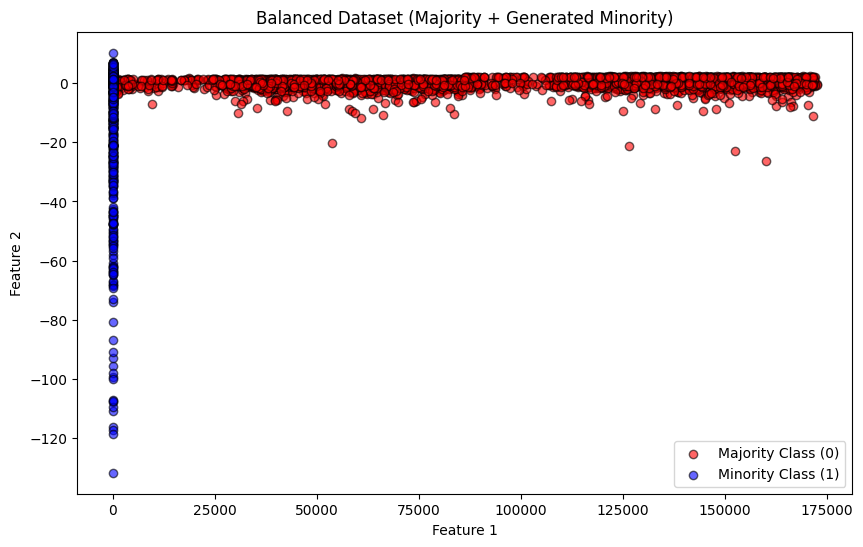

F1 Score on Original Data: 0.6457
F1 Score on Balanced Data: 0.8092
Original F1 Score: 0.6457
Balanced (Generated) F1 Score: 0.8092


In [6]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load credit card dataset from Google Drive
data_path = '/content/drive/MyDrive/creditcard.csv'  # Adjust the path as per your folder structure
df = pd.read_csv(data_path)

# Display the first few rows of the dataset
print(df.head())

# Assuming 'Class' is the target column (where 1 is fraud and 0 is not)
df['target'] = df['Class']
df = df.drop(columns=['Class'])

# Extract features (excluding time-related columns if necessary)
features = df.drop(columns=['target'])

# Step 2: Identify the minority class
minority_class = df[df['target'] == 1]
majority_class = df[df['target'] == 0]

# Plot the original imbalanced dataset (example for two features, modify as necessary)
def plot_data(original_df, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(original_df[original_df['target'] == 0].iloc[:, 0], original_df[original_df['target'] == 0].iloc[:, 1],
                label='Majority Class (0)', color='red', alpha=0.6, edgecolor='k')
    plt.scatter(original_df[original_df['target'] == 1].iloc[:, 0], original_df[original_df['target'] == 1].iloc[:, 1],
                label='Minority Class (1)', color='blue', alpha=0.6, edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_data(df, title="Original Dataset (Imbalance)")

# Step 3: Split minority class data into train and test sets
train_minority, test_minority = train_test_split(minority_class, test_size=0.3, random_state=42)

# Normalize the minority class training data
train_data = train_minority.drop('target', axis=1)
train_data_tensor = torch.tensor(
    (train_data.values - train_data.values.mean(axis=0)) / train_data.values.std(axis=0),
    dtype=torch.float32
)

# Step 4: Diffusion Model Training
T = 1000  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alpha_bar_t = torch.sqrt(alphas_bar[t]).view(-1, 1)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alphas_bar[t]).view(-1, 1)
    return sqrt_alpha_bar_t * x_start + sqrt_one_minus_alpha_bar_t * noise

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x, t):
        time_emb = torch.sin(t.unsqueeze(1) * 0.01)
        x = torch.cat([x, time_emb], dim=1)
        return self.model(x)

def p_sample(model, x_t, t):
    noise_pred = model(x_t, t)
    beta_t = betas[t].view(-1, 1)
    alpha_t = alphas[t].view(-1, 1)
    alpha_bar_t = alphas_bar[t].view(-1, 1)
    sqrt_alpha_t = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
    mean = (1 / sqrt_alpha_t) * (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * noise_pred)
    noise = torch.randn_like(x_t) if t[0] > 0 else torch.zeros_like(x_t)
    return mean + torch.sqrt(beta_t) * noise

def generate_sample(model, input_dim, num_samples):
    x = torch.randn((num_samples, input_dim))
    for t in reversed(range(T)):
        t_tensor = torch.tensor([t] * num_samples)
        x = p_sample(model, x, t_tensor)
    return x

num_features = train_data_tensor.shape[1]
model = SimpleMLP(input_dim=num_features + 1, output_dim=num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 1000
batch_size = 16
for epoch in tqdm(range(epochs)):
    idx = np.random.randint(0, train_data_tensor.shape[0], size=batch_size)
    x_start = train_data_tensor[idx]
    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start, t, noise)
    noise_pred = model(x_noisy, t)
    loss = loss_fn(noise_pred, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Step 5: Generate synthetic samples
num_generated_samples = 500
generated_data = generate_sample(model, num_features, num_generated_samples)

# Convert generated samples to DataFrame
generated_df = pd.DataFrame(generated_data.detach().numpy(), columns=train_data.columns)
generated_df['target'] = 1

# Step 6: Combine generated minority samples with majority samples
selected_majority = majority_class.sample(n=3000, random_state=42)
balanced_df = pd.concat([selected_majority, generated_df])

# Plot the balanced dataset
plot_data(balanced_df, title="Balanced Dataset (Majority + Generated Minority)")

# Step 7: Logistic Regression on Original and Balanced Data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, random_state=42)
log_reg_orig = LogisticRegression(solver='liblinear')
log_reg_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = log_reg_orig.predict(X_test_orig)
f1_score_orig = f1_score(y_test_orig, y_pred_orig)
print(f"F1 Score on Original Data: {f1_score_orig:.4f}")

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_df.drop('target', axis=1), balanced_df['target'], test_size=0.3, random_state=42)
log_reg_balanced = LogisticRegression(solver='liblinear')
log_reg_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = log_reg_balanced.predict(X_test_balanced)
f1_score_balanced = f1_score(y_test_balanced, y_pred_balanced)
print(f"F1 Score on Balanced Data: {f1_score_balanced:.4f}")

# Comparison of F1 Scores
print(f"Original F1 Score: {f1_score_orig:.4f}")
print(f"Balanced (Generated) F1 Score: {f1_score_balanced:.4f}")


# **MLP_Creditcard_Xgboost**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.1755

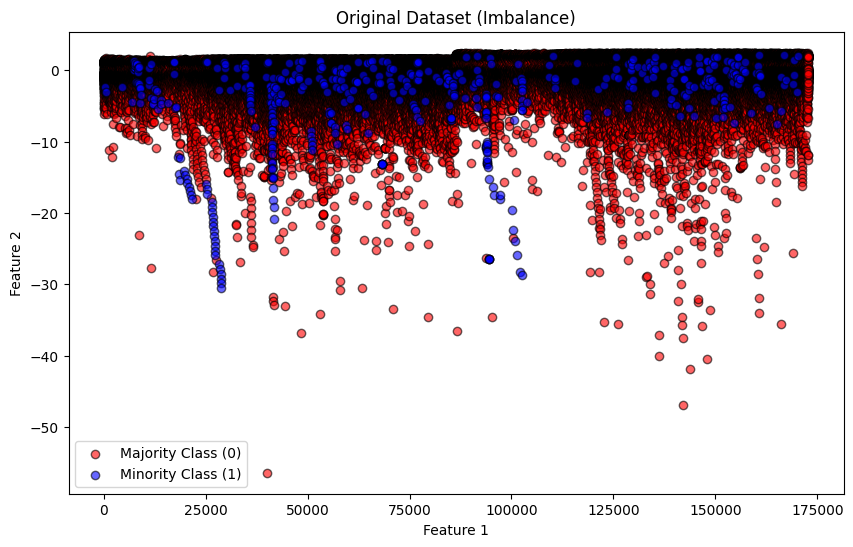

  4%|▍         | 39/1000 [00:00<00:04, 195.69it/s]

Epoch 0, Loss: 0.9897671341896057


 12%|█▏        | 122/1000 [00:00<00:04, 195.41it/s]

Epoch 100, Loss: 0.6574998497962952


 20%|██        | 204/1000 [00:01<00:07, 103.97it/s]

Epoch 200, Loss: 0.37650471925735474


 32%|███▏      | 323/1000 [00:02<00:06, 107.88it/s]

Epoch 300, Loss: 0.30275312066078186


 41%|████      | 412/1000 [00:03<00:06, 97.14it/s]

Epoch 400, Loss: 0.39140912890434265


 52%|█████▏    | 516/1000 [00:04<00:04, 103.73it/s]

Epoch 500, Loss: 0.3228714168071747


 64%|██████▍   | 642/1000 [00:05<00:01, 190.84it/s]

Epoch 600, Loss: 0.2849188446998596


 72%|███████▎  | 725/1000 [00:05<00:01, 201.92it/s]

Epoch 700, Loss: 0.17624163627624512


 85%|████████▍ | 848/1000 [00:06<00:00, 243.03it/s]

Epoch 800, Loss: 0.30053600668907166


 93%|█████████▎| 926/1000 [00:06<00:00, 203.55it/s]

Epoch 900, Loss: 0.2645242512226105


100%|██████████| 1000/1000 [00:06<00:00, 145.63it/s]


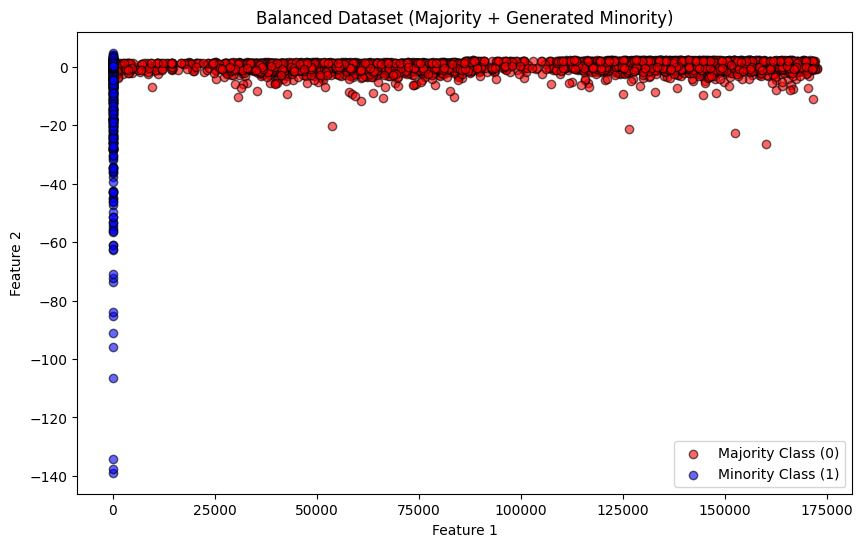

F1 Score on Original Data: 0.8706
F1 Score on Balanced Data: 0.9968
Original F1 Score: 0.8706
Balanced (Generated) F1 Score: 0.9968


In [7]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from google.colab import drive
import xgboost as xgb

# Mount Google Drive
drive.mount('/content/drive')

# Load credit card dataset from Google Drive
data_path = '/content/drive/My Drive/creditcard.csv'  # Adjust the path as per your folder structure
df = pd.read_csv(data_path)

# Display the first few rows of the dataset
print(df.head())

# Assuming 'Class' is the target column (where 1 is fraud and 0 is not)
df['target'] = df['Class']
df = df.drop(columns=['Class'])

# Extract features (excluding time-related columns if necessary)
features = df.drop(columns=['target'])

# Step 2: Identify the minority class
minority_class = df[df['target'] == 1]
majority_class = df[df['target'] == 0]

# Plot the original imbalanced dataset (example for two features, modify as necessary)
def plot_data(original_df, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(original_df[original_df['target'] == 0].iloc[:, 0], original_df[original_df['target'] == 0].iloc[:, 1],
                label='Majority Class (0)', color='red', alpha=0.6, edgecolor='k')
    plt.scatter(original_df[original_df['target'] == 1].iloc[:, 0], original_df[original_df['target'] == 1].iloc[:, 1],
                label='Minority Class (1)', color='blue', alpha=0.6, edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_data(df, title="Original Dataset (Imbalance)")

# Step 3: Split minority class data into train and test sets
train_minority, test_minority = train_test_split(minority_class, test_size=0.3, random_state=42)

# Normalize the minority class training data
train_data = train_minority.drop('target', axis=1)
train_data_tensor = torch.tensor(
    (train_data.values - train_data.values.mean(axis=0)) / train_data.values.std(axis=0),
    dtype=torch.float32
)

# Step 4: Diffusion Model Training
T = 1000  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alpha_bar_t = torch.sqrt(alphas_bar[t]).view(-1, 1)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alphas_bar[t]).view(-1, 1)
    return sqrt_alpha_bar_t * x_start + sqrt_one_minus_alpha_bar_t * noise

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x, t):
        time_emb = torch.sin(t.unsqueeze(1) * 0.01)
        x = torch.cat([x, time_emb], dim=1)
        return self.model(x)

def p_sample(model, x_t, t):
    noise_pred = model(x_t, t)
    beta_t = betas[t].view(-1, 1)
    alpha_t = alphas[t].view(-1, 1)
    alpha_bar_t = alphas_bar[t].view(-1, 1)
    sqrt_alpha_t = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
    mean = (1 / sqrt_alpha_t) * (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * noise_pred)
    noise = torch.randn_like(x_t) if t[0] > 0 else torch.zeros_like(x_t)
    return mean + torch.sqrt(beta_t) * noise

def generate_sample(model, input_dim, num_samples):
    x = torch.randn((num_samples, input_dim))
    for t in reversed(range(T)):
        t_tensor = torch.tensor([t] * num_samples)
        x = p_sample(model, x, t_tensor)
    return x

num_features = train_data_tensor.shape[1]
model = SimpleMLP(input_dim=num_features + 1, output_dim=num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 1000
batch_size = 16
for epoch in tqdm(range(epochs)):
    idx = np.random.randint(0, train_data_tensor.shape[0], size=batch_size)
    x_start = train_data_tensor[idx]
    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start, t, noise)
    noise_pred = model(x_noisy, t)
    loss = loss_fn(noise_pred, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Step 5: Generate synthetic samples
num_generated_samples = 500
generated_data = generate_sample(model, num_features, num_generated_samples)

# Convert generated samples to DataFrame
generated_df = pd.DataFrame(generated_data.detach().numpy(), columns=train_data.columns)
generated_df['target'] = 1

# Step 6: Combine generated minority samples with majority samples
selected_majority = majority_class.sample(n=3000, random_state=42)
balanced_df = pd.concat([selected_majority, generated_df])

# Plot the balanced dataset
plot_data(balanced_df, title="Balanced Dataset (Majority + Generated Minority)")

# Step 7: XGBoost Classifier on Original and Balanced Data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, random_state=42)

# Convert the training and test sets into DMatrix, a required format for XGBoost
dtrain_orig = xgb.DMatrix(X_train_orig, label=y_train_orig)
dtest_orig = xgb.DMatrix(X_test_orig, label=y_test_orig)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

# Train XGBoost on the original dataset
bst_orig = xgb.train(params, dtrain_orig, num_boost_round=100)
y_pred_orig = (bst_orig.predict(dtest_orig) > 0.5).astype(int)
f1_score_orig = f1_score(y_test_orig, y_pred_orig)
print(f"F1 Score on Original Data: {f1_score_orig:.4f}")

# Train XGBoost on the balanced dataset
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_df.drop('target', axis=1), balanced_df['target'], test_size=0.3, random_state=42)
dtrain_balanced = xgb.DMatrix(X_train_balanced, label=y_train_balanced)
dtest_balanced = xgb.DMatrix(X_test_balanced, label=y_test_balanced)

bst_balanced = xgb.train(params, dtrain_balanced, num_boost_round=100)
y_pred_balanced = (bst_balanced.predict(dtest_balanced) > 0.5).astype(int)
f1_score_balanced = f1_score(y_test_balanced, y_pred_balanced)
print(f"F1 Score on Balanced Data: {f1_score_balanced:.4f}")

# Comparison of F1 Scores
print(f"Original F1 Score: {f1_score_orig:.4f}")
print(f"Balanced (Generated) F1 Score: {f1_score_balanced:.4f}")


# **Using Fully Connected Layers_Fabricated Data**



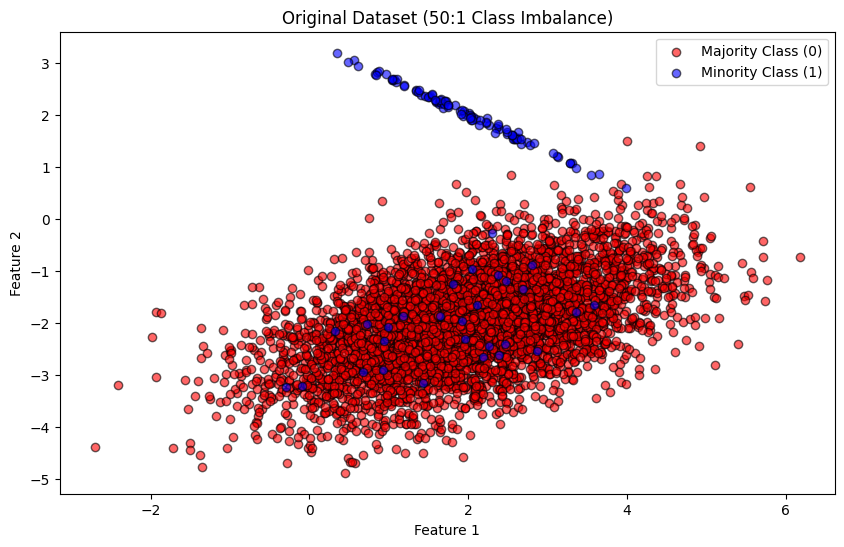

  1%|          | 9/1000 [00:00<00:29, 33.24it/s]

Epoch 0, Loss: 0.7767144441604614


 11%|█         | 112/1000 [00:01<00:08, 101.40it/s]

Epoch 100, Loss: 0.35057494044303894


 23%|██▎       | 233/1000 [00:01<00:03, 201.40it/s]

Epoch 200, Loss: 0.5279251933097839


 33%|███▎      | 333/1000 [00:02<00:03, 219.11it/s]

Epoch 300, Loss: 0.2727683186531067


 43%|████▎     | 431/1000 [00:03<00:03, 172.03it/s]

Epoch 400, Loss: 0.22529174387454987


 52%|█████▏    | 521/1000 [00:03<00:02, 164.00it/s]

Epoch 500, Loss: 0.12153081595897675


 62%|██████▏   | 617/1000 [00:04<00:02, 149.44it/s]

Epoch 600, Loss: 0.15568821132183075


 74%|███████▍  | 743/1000 [00:05<00:01, 186.18it/s]

Epoch 700, Loss: 0.4002811908721924


 83%|████████▎ | 834/1000 [00:05<00:00, 213.59it/s]

Epoch 800, Loss: 0.19283424317836761


 94%|█████████▍| 943/1000 [00:05<00:00, 240.23it/s]

Epoch 900, Loss: 0.35907071828842163


100%|██████████| 1000/1000 [00:06<00:00, 159.81it/s]


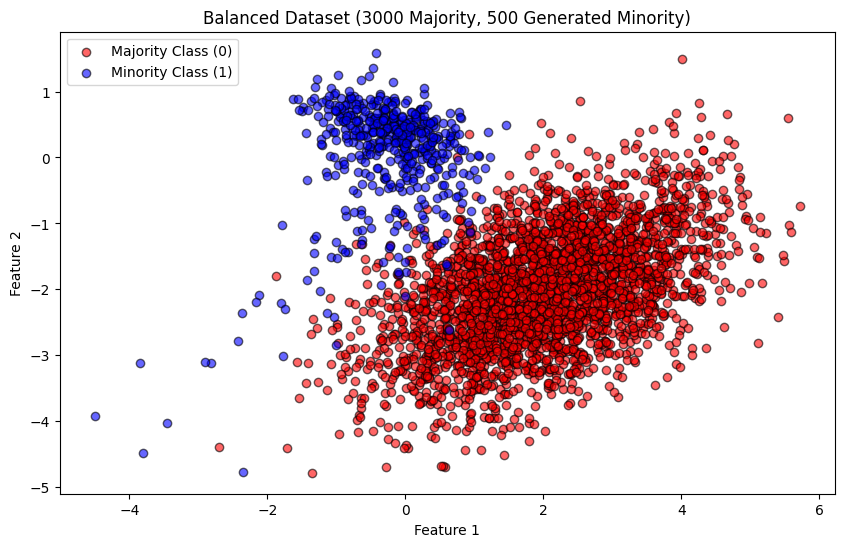

F1 Score on Original Data: 0.8116
F1 Score on Balanced Data: 0.9548
Original F1 Score: 0.8116
Balanced (Generated) F1 Score: 0.9548


In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Diffusion Hyperparameters
T = 1000  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)  # Shape (T,)
alphas = 1 - betas  # Shape (T,)
alphas_bar = torch.cumprod(alphas, dim=0)  # Shape (T,)

# Helper to add noise in the forward diffusion process
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alpha_bar_t = torch.sqrt(alphas_bar[t]).view(-1, 1)  # (batch_size, 1)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alphas_bar[t]).view(-1, 1)  # (batch_size, 1)
    return sqrt_alpha_bar_t * x_start + sqrt_one_minus_alpha_bar_t * noise

# Fully Connected Network with moderate complexity
class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FullyConnectedNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),  # Fewer neurons in hidden layers
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x, t):
        time_emb = torch.sin(t.unsqueeze(1) * 0.01)  # Sinusoidal time embedding
        x = torch.cat([x, time_emb], dim=1)
        return self.model(x)

# Reverse process (denoising)
def p_sample(model, x_t, t):
    noise_pred = model(x_t, t)
    beta_t = betas[t].view(-1, 1)
    alpha_t = alphas[t].view(-1, 1)
    alpha_bar_t = alphas_bar[t].view(-1, 1)
    sqrt_alpha_t = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
    mean = (1 / sqrt_alpha_t) * (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * noise_pred)
    noise = torch.randn_like(x_t) if t[0] > 0 else torch.zeros_like(x_t)
    return mean + torch.sqrt(beta_t) * noise

# Sampling process to generate data
def generate_sample(model, input_dim, num_samples):
    x = torch.randn((num_samples, input_dim))
    for t in reversed(range(T)):
        t_tensor = torch.tensor([t] * num_samples)
        x = p_sample(model, x, t_tensor)
    return x

# Step 1: Generate Synthetic Binary Dataset (50:1 ratio)
X, y = make_classification(n_samples=5000, n_features=2, n_classes=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_clusters_per_class=1, weights=[0.98, 0.02],
                           class_sep=2, random_state=42)

df = pd.DataFrame(X, columns=["Feature 1", "Feature 2"])
df['target'] = y

# Step 2: Identify the minority class
minority_class = df[df['target'] == 1]
majority_class = df[df['target'] == 0]

# Plot the dataset
def plot_data(data, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[data['target'] == 0]['Feature 1'], data[data['target'] == 0]['Feature 2'],
                label='Majority Class (0)', color='red', alpha=0.6, edgecolor='k')
    plt.scatter(data[data['target'] == 1]['Feature 1'], data[data['target'] == 1]['Feature 2'],
                label='Minority Class (1)', color='blue', alpha=0.6, edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_data(df, title="Original Dataset (50:1 Class Imbalance)")

# Step 3: Split minority class data into train and test sets
train_minority, test_minority = train_test_split(minority_class, test_size=0.3, random_state=42)

# Normalize the minority class training data
train_data = train_minority.drop('target', axis=1)
train_data_tensor = torch.tensor(
    (train_data.values - train_data.values.mean(axis=0)) / train_data.values.std(axis=0),
    dtype=torch.float32
)

# Step 4: Train the Diffusion Model on the minority class training data
num_features = train_data_tensor.shape[1]
model = FullyConnectedNetwork(input_dim=num_features + 1, output_dim=num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 1000
batch_size = 16
for epoch in tqdm(range(epochs)):
    idx = np.random.randint(0, train_data_tensor.shape[0], size=batch_size)
    x_start = train_data_tensor[idx]
    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start, t, noise)
    noise_pred = model(x_noisy, t)
    loss = loss_fn(noise_pred, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Step 5: Generate 500 samples of the minority class
num_generated_samples = 500
generated_data = generate_sample(model, num_features, num_generated_samples)

# Convert generated samples to DataFrame
generated_df = pd.DataFrame(generated_data.detach().numpy(), columns=["Feature 1", "Feature 2"])
generated_df['target'] = 1  # Assign minority class label

# Step 6: Combine generated minority class with 3000 samples from the majority class
selected_majority = majority_class.sample(n=3000, random_state=42)
balanced_df = pd.concat([selected_majority, generated_df])

# Plot the balanced dataset
plot_data(balanced_df, title="Balanced Dataset (3000 Majority, 500 Generated Minority)")

# Step 7: Train Logistic Regression on Original Dataset
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, random_state=42)

log_reg_orig = LogisticRegression(solver='liblinear')
log_reg_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = log_reg_orig.predict(X_test_orig)
f1_score_orig = f1_score(y_test_orig, y_pred_orig)
print(f"F1 Score on Original Data: {f1_score_orig:.4f}")

# Step 8: Train Logistic Regression on Balanced Dataset
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_df.drop('target', axis=1), balanced_df['target'], test_size=0.3, random_state=42)

log_reg_balanced = LogisticRegression(solver='liblinear')
log_reg_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = log_reg_balanced.predict(X_test_balanced)
f1_score_balanced = f1_score(y_test_balanced, y_pred_balanced)
print(f"F1 Score on Balanced Data: {f1_score_balanced:.4f}")

# Comparison of F1 Scores
print(f"Original F1 Score: {f1_score_orig:.4f}")
print(f"Balanced (Generated) F1 Score: {f1_score_balanced:.4f}")


# **FCN_Creditcard_Xgboost**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.1755

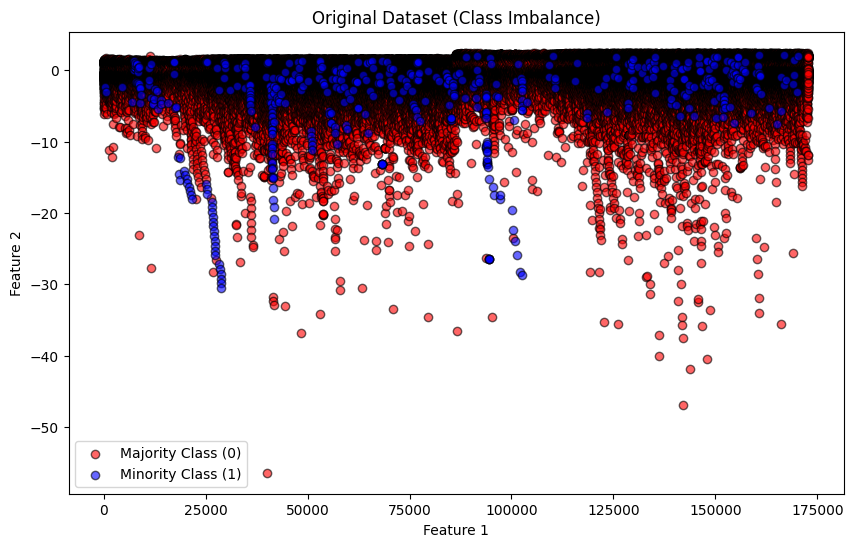

  2%|▎         | 25/1000 [00:00<00:03, 246.84it/s]

Epoch 0, Loss: 0.9773293733596802


 16%|█▋        | 163/1000 [00:00<00:02, 282.21it/s]

Epoch 100, Loss: 0.8359622359275818


 24%|██▎       | 235/1000 [00:00<00:02, 320.53it/s]

Epoch 200, Loss: 0.641227662563324


 33%|███▎      | 328/1000 [00:01<00:02, 283.82it/s]

Epoch 300, Loss: 0.7318609952926636


 43%|████▎     | 430/1000 [00:01<00:02, 213.76it/s]

Epoch 400, Loss: 0.5575354099273682


 53%|█████▎    | 528/1000 [00:02<00:03, 151.79it/s]

Epoch 500, Loss: 0.4966714680194855


 64%|██████▍   | 638/1000 [00:02<00:01, 220.15it/s]

Epoch 600, Loss: 0.3862658143043518


 74%|███████▍  | 741/1000 [00:03<00:01, 239.03it/s]

Epoch 700, Loss: 0.45429176092147827


 84%|████████▍ | 843/1000 [00:03<00:00, 235.17it/s]

Epoch 800, Loss: 0.29259243607521057


 91%|█████████ | 911/1000 [00:04<00:00, 186.98it/s]

Epoch 900, Loss: 0.4037705063819885


100%|██████████| 1000/1000 [00:04<00:00, 210.90it/s]


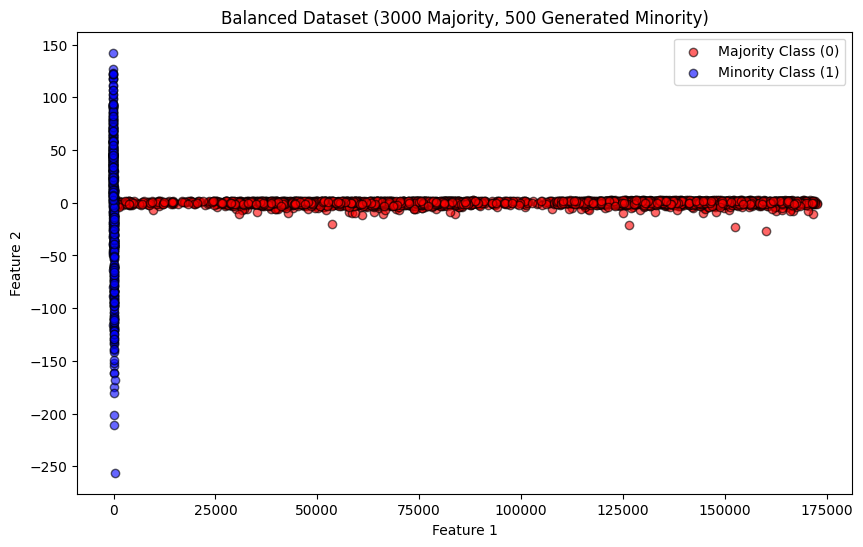

F1 Score on Original Data: 0.8706
F1 Score on Balanced Data: 0.9968
Original F1 Score: 0.8706
Balanced (Generated) F1 Score: 0.9968


In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from google.colab import drive
import xgboost as xgb

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

# Load credit card dataset from Google Drive
data_path = '/content/drive/My Drive/creditcard.csv'  # Adjust the path based on your folder structure
df = pd.read_csv(data_path)

# Display the first few rows of the dataset
print(df.head())

# Assuming 'Class' is the target column (1 = fraud, 0 = not fraud)
df['target'] = df['Class']
df = df.drop(columns=['Class'])

# Extract features (excluding any unnecessary columns like 'Time')
features = df.drop(columns=['target'])

# Step 2: Identify the minority and majority classes
minority_class = df[df['target'] == 1]
majority_class = df[df['target'] == 0]

# Plot the dataset (example for two features; modify as needed)
def plot_data(data, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[data['target'] == 0].iloc[:, 0], data[data['target'] == 0].iloc[:, 1],
                label='Majority Class (0)', color='red', alpha=0.6, edgecolor='k')
    plt.scatter(data[data['target'] == 1].iloc[:, 0], data[data['target'] == 1].iloc[:, 1],
                label='Minority Class (1)', color='blue', alpha=0.6, edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_data(df, title="Original Dataset (Class Imbalance)")

# Step 3: Split minority class data into train and test sets
train_minority, test_minority = train_test_split(minority_class, test_size=0.3, random_state=42)

# Normalize the minority class training data
train_data = train_minority.drop('target', axis=1)
train_data_tensor = torch.tensor(
    (train_data.values - train_data.values.mean(axis=0)) / train_data.values.std(axis=0),
    dtype=torch.float32
)

# Diffusion Hyperparameters
T = 1000  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)  # Shape (T,)
alphas = 1 - betas  # Shape (T,)
alphas_bar = torch.cumprod(alphas, dim=0)  # Shape (T,)

# Helper to add noise in the forward diffusion process
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alpha_bar_t = torch.sqrt(alphas_bar[t]).view(-1, 1)  # (batch_size, 1)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alphas_bar[t]).view(-1, 1)  # (batch_size, 1)
    return sqrt_alpha_bar_t * x_start + sqrt_one_minus_alpha_bar_t * noise

# Fully Connected Network for diffusion model
class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FullyConnectedNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x, t):
        time_emb = torch.sin(t.unsqueeze(1) * 0.01)  # Sinusoidal time embedding
        x = torch.cat([x, time_emb], dim=1)
        return self.model(x)

# Reverse process (denoising)
def p_sample(model, x_t, t):
    noise_pred = model(x_t, t)
    beta_t = betas[t].view(-1, 1)
    alpha_t = alphas[t].view(-1, 1)
    alpha_bar_t = alphas_bar[t].view(-1, 1)
    sqrt_alpha_t = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
    mean = (1 / sqrt_alpha_t) * (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * noise_pred)
    noise = torch.randn_like(x_t) if t[0] > 0 else torch.zeros_like(x_t)
    return mean + torch.sqrt(beta_t) * noise

# Sampling process to generate data
def generate_sample(model, input_dim, num_samples):
    x = torch.randn((num_samples, input_dim))
    for t in reversed(range(T)):
        t_tensor = torch.tensor([t] * num_samples)
        x = p_sample(model, x, t_tensor)
    return x

# Step 4: Train the Diffusion Model on the minority class training data
num_features = train_data_tensor.shape[1]
model = FullyConnectedNetwork(input_dim=num_features + 1, output_dim=num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 1000
batch_size = 16
for epoch in tqdm(range(epochs)):
    idx = np.random.randint(0, train_data_tensor.shape[0], size=batch_size)
    x_start = train_data_tensor[idx]
    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start, t, noise)
    noise_pred = model(x_noisy, t)
    loss = loss_fn(noise_pred, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Step 5: Generate 500 samples of the minority class
num_generated_samples = 500
generated_data = generate_sample(model, num_features, num_generated_samples)

# Convert generated samples to DataFrame
generated_df = pd.DataFrame(generated_data.detach().numpy(), columns=train_data.columns)
generated_df['target'] = 1  # Assign minority class label

# Step 6: Combine generated minority class with 3000 samples from the majority class
selected_majority = majority_class.sample(n=3000, random_state=42)
balanced_df = pd.concat([selected_majority, generated_df])

# Plot the balanced dataset
plot_data(balanced_df, title="Balanced Dataset (3000 Majority, 500 Generated Minority)")

# Step 7: Train XGBoost on Original Dataset
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, random_state=42)

# Convert to DMatrix for XGBoost
dtrain_orig = xgb.DMatrix(X_train_orig, label=y_train_orig)
dtest_orig = xgb.DMatrix(X_test_orig, label=y_test_orig)

# XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

# Train XGBoost on original data
bst_orig = xgb.train(params, dtrain_orig, num_boost_round=100)
y_pred_orig = (bst_orig.predict(dtest_orig) > 0.5).astype(int)
f1_score_orig = f1_score(y_test_orig, y_pred_orig)
print(f"F1 Score on Original Data: {f1_score_orig:.4f}")

# Step 8: Train XGBoost on Balanced Dataset
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_df.drop('target', axis=1), balanced_df['target'], test_size=0.3, random_state=42)

# Convert to DMatrix for XGBoost
dtrain_balanced = xgb.DMatrix(X_train_balanced, label=y_train_balanced)
dtest_balanced = xgb.DMatrix(X_test_balanced, label=y_test_balanced)

# Train XGBoost on balanced data
bst_balanced = xgb.train(params, dtrain_balanced, num_boost_round=100)
y_pred_balanced = (bst_balanced.predict(dtest_balanced) > 0.5).astype(int)
f1_score_balanced = f1_score(y_test_balanced, y_pred_balanced)
print(f"F1 Score on Balanced Data: {f1_score_balanced:.4f}")

# Comparison of F1 Scores
print(f"Original F1 Score: {f1_score_orig:.4f}")
print(f"Balanced (Generated) F1 Score: {f1_score_balanced:.4f}")


# **Improved Model_Fabricated Data**

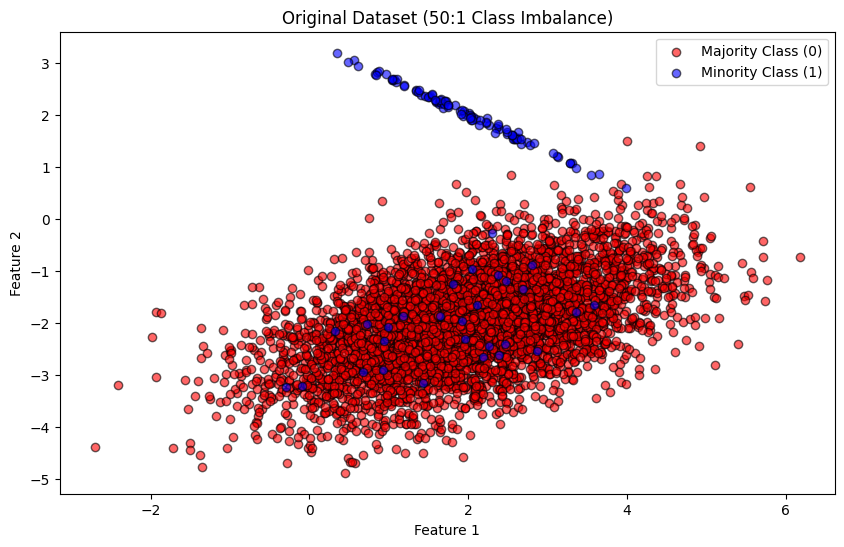

<ipython-input-2-5dbd09197366>:147: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-2-5dbd09197366>:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  2%|▏         | 9/500 [00:00<00:12, 39.46it/s]

Epoch 0, Loss: 0.5553184747695923


 11%|█         | 56/500 [00:01<00:07, 59.09it/s]

Epoch 50, Loss: 0.23540012538433075


 21%|██        | 105/500 [00:02<00:08, 48.18it/s]

Epoch 100, Loss: 0.37188833951950073


 33%|███▎      | 165/500 [00:03<00:04, 71.19it/s]

Epoch 150, Loss: 0.24632710218429565


 42%|████▏     | 211/500 [00:03<00:04, 60.27it/s]

Epoch 200, Loss: 0.1629364788532257


 52%|█████▏    | 259/500 [00:05<00:05, 43.37it/s]

Epoch 250, Loss: 0.28506073355674744


 61%|██████    | 306/500 [00:06<00:05, 34.40it/s]

Epoch 300, Loss: 0.29591041803359985


 71%|███████▏  | 357/500 [00:07<00:03, 37.25it/s]

Epoch 350, Loss: 0.20473137497901917


 81%|████████  | 404/500 [00:08<00:01, 55.87it/s]

Epoch 400, Loss: 0.19974951446056366


 90%|█████████ | 451/500 [00:09<00:00, 64.58it/s]

Epoch 450, Loss: 0.28388381004333496


100%|██████████| 500/500 [00:10<00:00, 47.52it/s]


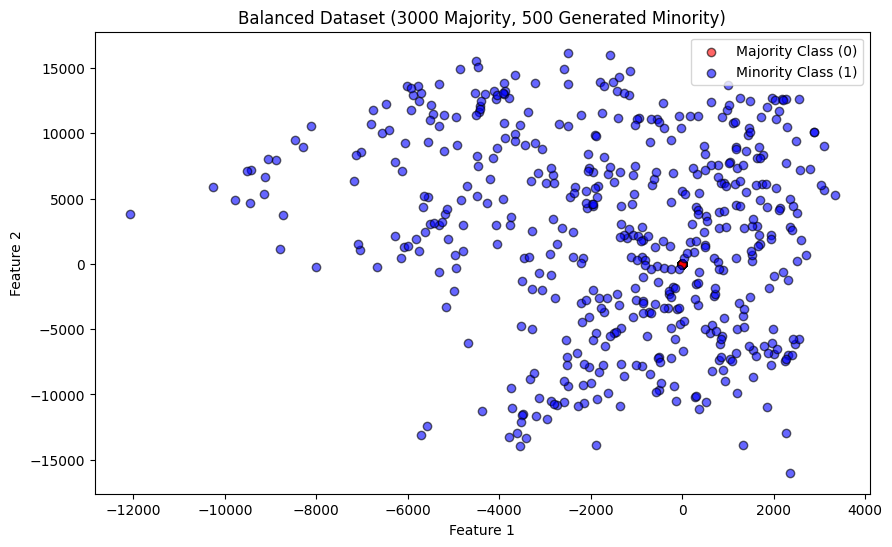

F1 Score on Original Data: 0.8116
F1 Score on Balanced Data: 0.5072
Original F1 Score: 0.8116
Balanced (Generated) F1 Score: 0.5072


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Custom Cosine Beta Schedule
def cosine_beta_schedule(timesteps, s=0.008):
    steps = np.arange(timesteps + 1, dtype=np.float64)
    alphas_cumprod = np.cos(((steps / timesteps) + s) / (1 + s) * np.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.from_numpy(np.clip(betas, 0, 0.999).astype(np.float32))

# Diffusion Hyperparameters
T = 500  # Reduced number of diffusion steps for efficiency
betas = cosine_beta_schedule(T)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

# Helper to add noise in the forward diffusion process
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alpha_bar_t = torch.sqrt(alphas_bar[t]).view(-1, 1)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alphas_bar[t]).view(-1, 1)
    return sqrt_alpha_bar_t * x_start + sqrt_one_minus_alpha_bar_t * noise

# Residual Block with Batch Normalization
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)

    def forward(self, x):
        identity = x
        out = self.linear1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out += identity  # Skip connection
        out = self.relu(out)
        return out

# Improved Network with Residual Blocks
class ImprovedNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ImprovedNetwork, self).__init__()
        self.initial_linear = nn.Linear(input_dim, 128)
        self.bn0 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.residual_blocks = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128)
        )
        self.output_linear = nn.Linear(128, output_dim)

    def forward(self, x, t):
        time_emb = torch.sin(t.unsqueeze(1) * 0.01)
        x = torch.cat([x, time_emb], dim=1)
        out = self.initial_linear(x)
        out = self.bn0(out)
        out = self.relu(out)
        out = self.residual_blocks(out)
        out = self.output_linear(out)
        return out

# Reverse process (denoising)
def p_sample(model, x_t, t):
    noise_pred = model(x_t, t)
    beta_t = betas[t].view(-1, 1)
    alpha_t = alphas[t].view(-1, 1)
    alpha_bar_t = alphas_bar[t].view(-1, 1)
    sqrt_alpha_t = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
    mean = (1 / sqrt_alpha_t) * (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * noise_pred)
    noise = torch.randn_like(x_t) if t[0] > 0 else torch.zeros_like(x_t)
    return mean + torch.sqrt(beta_t) * noise

# Sampling process to generate data
def generate_sample(model, input_dim, num_samples):
    x = torch.randn((num_samples, input_dim))
    for t in reversed(range(T)):
        t_tensor = torch.tensor([t] * num_samples)
        x = p_sample(model, x, t_tensor)
    return x

# Step 1: Generate Synthetic Binary Dataset (50:1 ratio)
X, y = make_classification(n_samples=5000, n_features=2, n_classes=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_clusters_per_class=1, weights=[0.98, 0.02],
                           class_sep=2, random_state=42)

df = pd.DataFrame(X, columns=["Feature 1", "Feature 2"])
df['target'] = y

# Step 2: Identify the minority class
minority_class = df[df['target'] == 1]
majority_class = df[df['target'] == 0]

# Plot the dataset
def plot_data(data, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[data['target'] == 0]['Feature 1'], data[data['target'] == 0]['Feature 2'],
                label='Majority Class (0)', color='red', alpha=0.6, edgecolor='k')
    plt.scatter(data[data['target'] == 1]['Feature 1'], data[data['target'] == 1]['Feature 2'],
                label='Minority Class (1)', color='blue', alpha=0.6, edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_data(df, title="Original Dataset (50:1 Class Imbalance)")

# Step 3: Split minority class data into train and test sets
train_minority, test_minority = train_test_split(minority_class, test_size=0.3, random_state=42)

# Normalize the minority class training data
train_data = train_minority.drop('target', axis=1)
train_data_tensor = torch.tensor(
    (train_data.values - train_data.values.mean(axis=0)) / train_data.values.std(axis=0),
    dtype=torch.float32
)

# Step 4: Train the Improved Diffusion Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_features = train_data_tensor.shape[1]
model = ImprovedNetwork(input_dim=num_features + 1, output_dim=num_features).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
loss_fn = nn.SmoothL1Loss()  # Alternative loss function
max_norm = 1.0  # For gradient clipping

epochs = 500  # Reduced epochs due to improved efficiency
batch_size = 32  # Increased batch size
scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

for epoch in tqdm(range(epochs)):
    idx = np.random.randint(0, train_data_tensor.shape[0], size=batch_size)
    x_start = train_data_tensor[idx].to(device)
    t = torch.randint(0, T, (batch_size,)).to(device)
    noise = torch.randn_like(x_start).to(device)
    x_noisy = q_sample(x_start, t, noise)

    with torch.cuda.amp.autocast():  # Mixed precision
        noise_pred = model(x_noisy, t)
        loss = loss_fn(noise_pred, noise)

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)  # Gradient clipping
    scaler.step(optimizer)
    scaler.update()
    scheduler.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Step 5: Generate 500 samples of the minority class
num_generated_samples = 500
generated_data = generate_sample(model, num_features, num_generated_samples).cpu().detach()

# Denormalize generated data
mean = train_data.values.mean(axis=0)
std = train_data.values.std(axis=0)
generated_data = generated_data * std + mean

# Convert generated samples to DataFrame
generated_df = pd.DataFrame(generated_data.numpy(), columns=["Feature 1", "Feature 2"])
generated_df['target'] = 1  # Assign minority class label

# Step 6: Combine generated minority class with 3000 samples from the majority class
selected_majority = majority_class.sample(n=3000, random_state=42)
balanced_df = pd.concat([selected_majority, generated_df])

# Plot the balanced dataset
plot_data(balanced_df, title="Balanced Dataset (3000 Majority, 500 Generated Minority)")

# Step 7: Train Logistic Regression on Original Dataset
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, random_state=42)

log_reg_orig = LogisticRegression(solver='liblinear')
log_reg_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = log_reg_orig.predict(X_test_orig)
f1_score_orig = f1_score(y_test_orig, y_pred_orig)
print(f"F1 Score on Original Data: {f1_score_orig:.4f}")

# Step 8: Train Logistic Regression on Balanced Dataset
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_df.drop('target', axis=1), balanced_df['target'], test_size=0.3, random_state=42)

log_reg_balanced = LogisticRegression(solver='liblinear')
log_reg_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = log_reg_balanced.predict(X_test_balanced)
f1_score_balanced = f1_score(y_test_balanced, y_pred_balanced)
print(f"F1 Score on Balanced Data: {f1_score_balanced:.4f}")

# Comparison of F1 Scores
print(f"Original F1 Score: {f1_score_orig:.4f}")
print(f"Balanced (Generated) F1 Score: {f1_score_balanced:.4f}")


# **Improved_creditcard_xgboost**

In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import xgboost as xgb

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

# Load credit card dataset from Google Drive
data_path = '/content/drive/My Drive/creditcard.csv'  # Adjust the path based on your folder structure
df = pd.read_csv(data_path)

# Step 1: Identify features and target
features = df.drop('Class', axis=1)
target = df['Class']

# Step 2: Normalize the features (for diffusion process)
features_normalized = (features - features.mean()) / features.std()

# Split the dataset into majority (Class 0) and minority (Class 1)
minority_class = df[df['Class'] == 1]
majority_class = df[df['Class'] == 0]

# Plot the dataset distribution (optional)
print("Class Distribution:\n", df['Class'].value_counts())

# Step 3: Split minority class data into train and test sets
train_minority, test_minority = train_test_split(minority_class, test_size=0.3, random_state=42)

# Normalize the minority class training data
train_data = train_minority.drop('Class', axis=1)
train_data_tensor = torch.tensor(
    (train_data.values - train_data.values.mean(axis=0)) / train_data.values.std(axis=0),
    dtype=torch.float32
)

# Residual Block for Diffusion Model
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)

    def forward(self, x):
        identity = x
        out = self.linear1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out += identity  # Skip connection
        out = self.relu(out)
        return out

# Improved Network with Residual Blocks
class ImprovedNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ImprovedNetwork, self).__init__()
        self.initial_linear = nn.Linear(input_dim, 128)
        self.bn0 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.residual_blocks = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128)
        )
        self.output_linear = nn.Linear(128, output_dim)

    def forward(self, x, t):
        time_emb = torch.sin(t.unsqueeze(1) * 0.01)
        x = torch.cat([x, time_emb], dim=1)
        out = self.initial_linear(x)
        out = self.bn0(out)
        out = self.relu(out)
        out = self.residual_blocks(out)
        out = self.output_linear(out)
        return out

# Step 4: Train the Improved Diffusion Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_features = train_data_tensor.shape[1]
model = ImprovedNetwork(input_dim=num_features + 1, output_dim=num_features).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
loss_fn = nn.SmoothL1Loss()
max_norm = 1.0

epochs = 500
batch_size = 32
scaler = torch.cuda.amp.GradScaler()

for epoch in tqdm(range(epochs)):
    idx = np.random.randint(0, train_data_tensor.shape[0], size=batch_size)
    x_start = train_data_tensor[idx].to(device)
    t = torch.randint(0, T, (batch_size,)).to(device)
    noise = torch.randn_like(x_start).to(device)
    x_noisy = q_sample(x_start, t, noise)

    with torch.cuda.amp.autocast():
        noise_pred = model(x_noisy, t)
        loss = loss_fn(noise_pred, noise)

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
    scaler.step(optimizer)
    scaler.update()
    scheduler.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Step 5: Generate 500 samples of the minority class
num_generated_samples = 500
generated_data = generate_sample(model, num_features, num_generated_samples).cpu().detach()

# Denormalize generated data
mean = train_data.values.mean(axis=0)
std = train_data.values.std(axis=0)
generated_data = generated_data * std + mean

# Convert generated samples to DataFrame
generated_df = pd.DataFrame(generated_data.numpy(), columns=features.columns)
generated_df['Class'] = 1  # Assign minority class label

# Step 6: Combine generated minority class with a subset of the majority class
selected_majority = majority_class.sample(n=3000, random_state=42)
balanced_df = pd.concat([selected_majority, generated_df])

# Step 7: Train XGBoost on the original dataset
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(features, target, test_size=0.3, random_state=42)

xgb_model_orig = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = xgb_model_orig.predict(X_test_orig)
f1_score_orig = f1_score(y_test_orig, y_pred_orig)
print(f"F1 Score on Original Data: {f1_score_orig:.4f}")

# Step 8: Train XGBoost on the balanced dataset
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_df.drop('Class', axis=1), balanced_df['Class'], test_size=0.3, random_state=42)

xgb_model_balanced = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = xgb_model_balanced.predict(X_test_balanced)
f1_score_balanced = f1_score(y_test_balanced, y_pred_balanced)
print(f"F1 Score on Balanced Data: {f1_score_balanced:.4f}")

# Comparison of F1 Scores
print(f"Original F1 Score: {f1_score_orig:.4f}")
print(f"Balanced (Generated) F1 Score: {f1_score_balanced:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-11-96c5a294f0fb>:97: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-11-96c5a294f0fb>:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  1%|▏         | 7/500 [00:00<00:07, 65.39it/s]

Epoch 0, Loss: 0.6060953736305237


 11%|█         | 53/500 [00:01<00:11, 38.71it/s]

Epoch 50, Loss: 0.36976179480552673


 24%|██▎       | 118/500 [00:01<00:03, 105.44it/s]

Epoch 100, Loss: 0.2908371686935425


 35%|███▍      | 173/500 [00:02<00:02, 127.04it/s]

Epoch 150, Loss: 0.22591711580753326


 46%|████▌     | 230/500 [00:02<00:01, 139.29it/s]

Epoch 200, Loss: 0.19594287872314453


 55%|█████▍    | 274/500 [00:02<00:01, 143.08it/s]

Epoch 250, Loss: 0.2402782440185547


 64%|██████▍   | 319/500 [00:03<00:01, 137.35it/s]

Epoch 300, Loss: 0.2264573574066162


 76%|███████▌  | 378/500 [00:03<00:00, 140.17it/s]

Epoch 350, Loss: 0.19814270734786987


 84%|████████▍ | 422/500 [00:03<00:00, 131.63it/s]

Epoch 400, Loss: 0.18878313899040222


 95%|█████████▌| 477/500 [00:04<00:00, 127.18it/s]

Epoch 450, Loss: 0.19797806441783905


100%|██████████| 500/500 [00:04<00:00, 108.59it/s]
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:32:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score on Original Data: 0.8706
F1 Score on Balanced Data: 0.9968
Original F1 Score: 0.8706
Balanced (Generated) F1 Score: 0.9968


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:32:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.1755

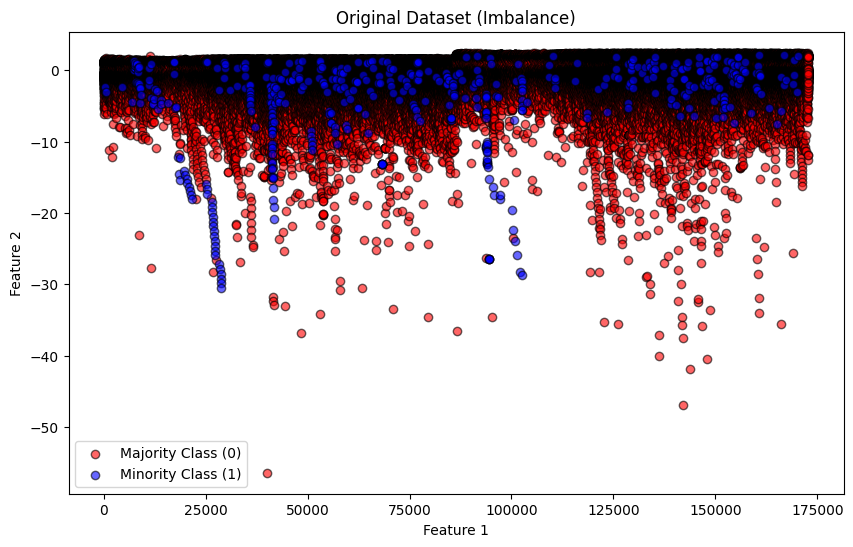

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16, 30])) that is different to the input size (torch.Size([16, 31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (31) must match the size of tensor b (30) at non-singleton dimension 1

In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from google.colab import drive
import xgboost as xgb

# Mount Google Drive
drive.mount('/content/drive')

# Load credit card dataset from Google Drive
data_path = '/content/drive/My Drive/creditcard.csv'  # Adjust the path as per your folder structure
df = pd.read_csv(data_path)

# Display the first few rows of the dataset
print(df.head())

# Assuming 'Class' is the target column (where 1 is fraud and 0 is not)
df['target'] = df['Class']
df = df.drop(columns=['Class'])

# Extract features (excluding time-related columns if necessary)
features = df.drop(columns=['target'])

# Step 2: Identify the minority class
minority_class = df[df['target'] == 1]
majority_class = df[df['target'] == 0]

# Plot the original imbalanced dataset (example for two features, modify as necessary)
def plot_data(original_df, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(original_df[original_df['target'] == 0].iloc[:, 0], original_df[original_df['target'] == 0].iloc[:, 1],
                label='Majority Class (0)', color='red', alpha=0.6, edgecolor='k')
    plt.scatter(original_df[original_df['target'] == 1].iloc[:, 0], original_df[original_df['target'] == 1].iloc[:, 1],
                label='Minority Class (1)', color='blue', alpha=0.6, edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_data(df, title="Original Dataset (Imbalance)")

# Step 3: Split minority class data into train and test sets
train_minority, test_minority = train_test_split(minority_class, test_size=0.3, random_state=42)

# Normalize the minority class training data
train_data = train_minority.drop('target', axis=1)
train_data_tensor = torch.tensor(
    (train_data.values - train_data.values.mean(axis=0)) / train_data.values.std(axis=0),
    dtype=torch.float32
)

# Step 4: Transformer-based Diffusion Model
T = 1000  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alpha_bar_t = torch.sqrt(alphas_bar[t]).view(-1, 1)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alphas_bar[t]).view(-1, 1)
    return sqrt_alpha_bar_t * x_start + sqrt_one_minus_alpha_bar_t * noise

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, n_heads, num_layers, hidden_dim):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t):
        time_emb = torch.sin(t.unsqueeze(1) * 0.01)
        x = torch.cat([x, time_emb], dim=1)
        x = self.embedding(x).unsqueeze(0)  # Transformer expects input of shape (seq_len, batch_size, embedding_dim)
        x = self.transformer_encoder(x).squeeze(0)
        return self.fc_out(x)

def p_sample(model, x_t, t):
    noise_pred = model(x_t, t)
    beta_t = betas[t].view(-1, 1)
    alpha_t = alphas[t].view(-1, 1)
    alpha_bar_t = alphas_bar[t].view(-1, 1)
    sqrt_alpha_t = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
    mean = (1 / sqrt_alpha_t) * (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * noise_pred)
    noise = torch.randn_like(x_t) if t[0] > 0 else torch.zeros_like(x_t)
    return mean + torch.sqrt(beta_t) * noise

def generate_sample(model, input_dim, num_samples):
    x = torch.randn((num_samples, input_dim))
    for t in reversed(range(T)):
        t_tensor = torch.tensor([t] * num_samples)
        x = p_sample(model, x, t_tensor)
    return x

# Step 5: Model training
num_features = train_data_tensor.shape[1]
model = SimpleTransformer(input_dim=num_features + 1, n_heads=2, num_layers=2, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 1000
batch_size = 16
for epoch in tqdm(range(epochs)):
    idx = np.random.randint(0, train_data_tensor.shape[0], size=batch_size)
    x_start = train_data_tensor[idx]
    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start, t, noise)
    noise_pred = model(x_noisy, t)
    loss = loss_fn(noise_pred, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Step 6: Generate synthetic samples
num_generated_samples = 500
generated_data = generate_sample(model, num_features, num_generated_samples)

# Convert generated samples to DataFrame
generated_df = pd.DataFrame(generated_data.detach().numpy(), columns=train_data.columns)
generated_df['target'] = 1

# Step 7: Combine generated minority samples with majority samples
selected_majority = majority_class.sample(n=3000, random_state=42)
balanced_df = pd.concat([selected_majority, generated_df])

# Plot the balanced dataset
plot_data(balanced_df, title="Balanced Dataset (Majority + Generated Minority)")

# Step 8: XGBoost Classifier on Original and Balanced Data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, random_state=42)

# Convert the training and test sets into DMatrix, a required format for XGBoost
dtrain_orig = xgb.DMatrix(X_train_orig, label=y_train_orig)
dtest_orig = xgb.DMatrix(X_test_orig, label=y_test_orig)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

# Train XGBoost on the original dataset
bst_orig = xgb.train(params, dtrain_orig, num_boost_round=100)
y_pred_orig = (bst_orig.predict(dtest_orig) > 0.5).astype(int)
f1_score_orig = f1_score(y_test_orig, y_pred_orig)
print(f"F1 Score on Original Data: {f1_score_orig:.4f}")

# Train XGBoost on the balanced dataset
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_df.drop('target', axis=1), balanced_df['target'], test_size=0.3, random_state=42)
dtrain_balanced = xgb.DMatrix(X_train_balanced, label=y_train_balanced)
dtest_balanced = xgb.DMatrix(X_test_balanced, label=y_test_balanced)

bst_balanced = xgb.train(params, dtrain_balanced, num_boost_round=100)
y_pred_balanced = (bst_balanced.predict(dtest_balanced) > 0.5).astype(int)
f1_score_balanced = f1_score(y_test_balanced, y_pred_balanced)
print(f"F1 Score on Balanced Data: {f1_score_balanced:.4f}")

# Comparison of F1 Scores
print(f"Original F1 Score: {f1_score_orig:.4f}")
print(f"Balanced (Generated) F1 Score: {f1_score_balanced:.4f}")
